In [1]:
#@title Imports & Utils
#!pip install -q git+https://www.github.com/google/jax-md

import time

from functools import partial
import numpy as onp

import jax.numpy as np

from jax import jit
from jax import grad
from jax import vmap
from jax import value_and_grad

from jax import random
from jax import lax

from jax.example_libraries import stax
from jax.example_libraries import optimizers

from jax.config import config
config.update('jax_enable_x64', True)

# NOTE(schsam): We need this in OSS I think.
from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

f32 = np.float32
f64 = np.float64

def draw_system(R, box_size, marker_size, color=None):
  if color == None:
    color = [64 / 256] * 3
  color = onp.array(color)
  ms = marker_size / box_size

  R = onp.array(R)

  marker_style = dict(
      linestyle='none',
      markeredgewidth=3,
      marker='o',
      markersize=ms,
      color=color,
      fillstyle='none')

  plt.plot(R[:, 0], R[:, 1], **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] - box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1] - box_size, **marker_style)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.axis('off')

def square_lattice(N, box_size):
  Nx = int(np.sqrt(N))
  Ny, ragged = divmod(N, Nx)
  if Ny != Nx or ragged:
    assert ValueError('Particle count should be a square. Found {}.'.format(N))
  length_scale = box_size / Nx
  R = []
  for i in range(Nx):
    for j in range(Ny):
      R.append([i * length_scale, j * length_scale])
  return np.array(R)

/tmp/ipykernel_26902/2486168622.py:22: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


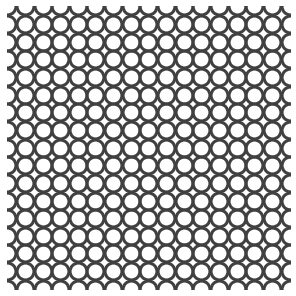

In [2]:
from jax_md import quantity

N = 256
box_size = quantity.box_size_at_number_density(particle_count=N,
                                               number_density=1.0,
                                               spatial_dimension=2)

r = square_lattice(N, box_size)
draw_system(r, box_size, 270.0)
finalize_plot((0.75, 0.75))

The positions, `r`, is just a numpy array and so we can shift the particles simply by adding a vector to `r`.

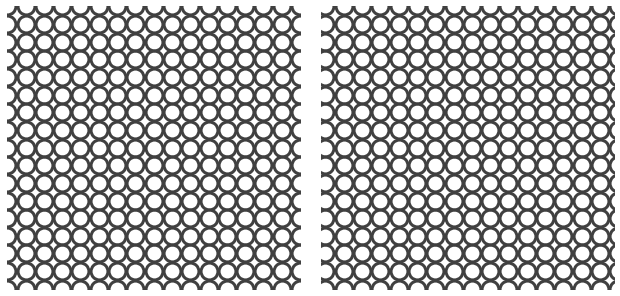

In [3]:
r_new = r + np.array([[0.25, 0]])

plt.subplot(1, 2, 1)
draw_system(r, box_size, 270.0)

plt.subplot(1, 2, 2)
draw_system(r_new, box_size, 270.0)

finalize_plot((1.5, 0.75))

Here, we are simulating a relatively small bubble raft. We can emulate a much larger bubble raft by combining our small simulation with periodic boundary conditions. Periodic boundary conditions are very common and they allow bubbles to wrap around the edges of the box like in the game "Asteroids". In JAX MD, we construct periodic boundary conditions using the function `space.periodic(box_size)` which returns a tuple of two functions, `(displacement_fn, shift_fn)`. The functions in the tuple do the following,

*   `dr_ij = displacement_fn(r_i, r_j)` takes a pair of positions and computes the displacement between them.
*   `r_p = shift_fn(r, delta_r)` takes a position and a shift and returns a new shifted position.

In [4]:
from jax_md import space

displacement_fn, shift_fn = space.periodic(box_size)

Next we need to posit interactions between our bubbles that simulate real bubbles. We'll assume that we can model a pair of bubbles by defining an energy function for the pair. We can use an energy that is zero if the bubbles aren't touching and then increases gradually as they get pushed together. Specifically, if $r_{ij}$ is the distance between bubble $i$ and $j$, we'll try out a function that looks like:

$$
U(r_{ij}) = \begin{cases}
  (1 - r_{ij})^2 & \text{if $r_{ij} < 1$} \\
  0 & \text{if $r_{ij}>1$}
  \end{cases}
$$  
When we run our simulation, by having bubbles move to try to minimize the energy between them they will naturally separate if they overlap.

This is implemented in JAX MD using the function `energy.soft_sphere(r)` which takes a distance and returns an energy.

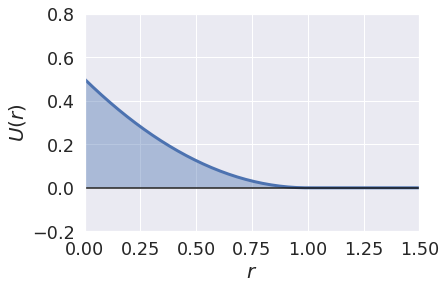

In [5]:
from jax_md import energy

dr = np.linspace(0, 3.0, num=80)
plt.plot(dr, energy.soft_sphere(dr), 'b-', linewidth=3)
plt.fill_between(dr, energy.soft_sphere(dr), alpha=0.4)

plt.gca().axhline(y=0, color='k')
plt.xlim([0, 1.5])
plt.ylim([-0.2, 0.8])

format_plot('$r$', '$U(r)$')

Once we've assigned an energy, $U(r_{ij})$, to pairs of bubbles, we have to assign an energy to to the whole system, $\mathcal U$. As we will see, our simulation will make use of the forces, $\vec F_i = -\nabla_{\vec r_i}\mathcal U$. This is usually done by just summing up all the pairwise energies,
$$\mathcal U = \frac12\sum_{ij}U(r_{ij}).$$
To compute the energy of the whole bubble raft in JAX, M.D. we use the helper function `energy_fn = energy.soft_sphere_pair(displacement_fn)` which returns a function that computes the soft-sphere energy for our bubble raft in its periodic box.

In [27]:
energy_fn = energy.soft_sphere_pair(displacement_fn)
print('Energy of the system, U = {:f}'.format(energy_fn(r)))

Energy of the system, U = 0.000000


We can now run an actual simulation our bubbles. We're going to use a simulation called [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). Brownian motion are described by a first-order differential equation relating the velocity of bubbles to the forces on them along with random kicks coming from the water,
$$\frac{d{\vec r}_i(t)}{dt} = \vec F_i(t) + \sqrt{2k_BT}\vec \xi_i(t).$$
Here $\vec F_i(t)$ are forces, $\vec \xi_i\sim\mathcal N(0, 1)$ is i.i.d. Gaussian distributed noise, and $k_BT$ specifies the temperature of the water. Incidentally, this model of objects in water [dates back to Einstein.](http://users.physik.fu-berlin.de/~kleinert/files/eins_brownian.pdf)

To simulate brownian motion we will need to draw the $\xi_i$ from a Gaussian distribution. In [JAX, random numbers](https://en.wikipedia.org/wiki/Brownian_motion) do not use global state. Instead we have to instantiate the state of random numbers explicitly using `random.PRNGKey(seed)`.



In [28]:
key = random.PRNGKey(0)

Simulations in JAX, MD are modeled after [JAX optimizers.](https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html?highlight=optimizers) To run a Brownian motion simulation we use the function `simulate.brownian(energy_fun, shift_fun, dt, temperature)` where `dt` is the time-step of the simulation and `temperature` is the simulated temperature; `simulate.brownian` return a pair of functions, `(init_fn, apply_fn)` which have the following properties,

*   `state = init_fn(key, r)` take the state of a random number generator and bubble positions. It returns a simulation state that might contain auxiliary information.
*   `state = apply_fn(state)` which increments the simulation by a step.

We can now setup some experimental parameters and create a simulation.


In [29]:
from jax_md import simulate

simulation_steps = 20000
write_every = 100
dt = 1e-1
temperature = 1e-5

init_fn, apply_fn = simulate.brownian(energy_fn, shift_fn, dt, temperature)

Normal execution in JAX executes each line as a separate call to the GPU. However, it can be significantly faster to compile entire functions into single device calls. To do this we use JAX's [just-in-time compilation](https://github.com/google/jax#compilation-with-jit), `jit`, to compile functions to XLA [XLA](https://www.tensorflow.org/xla)  which then get optimized and run as single device calls. The function `compiled_fun = jit(fun)` takes a function and returns a new compiled version of the function.

In [30]:
apply_fn = jit(apply_fn)

Now we can run the simulation. We will record the positions of the simulation every so often to visualize it later.

In [31]:
state = init_fn(key, r)
trajectory = []

for step in ProgressIter(range(simulation_steps)):
  state = apply_fn(state)
  if step % write_every == 0:
    trajectory += [state.position]

trajectory = np.stack(trajectory)

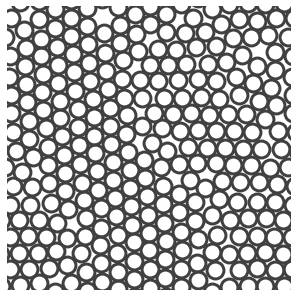

In [32]:
draw_system(state.position, box_size, 270.0)
finalize_plot((0.75, 0.75))

We see that our bubble raft has changed in structure from a square configuration to a hexagonal one spontaneously! Note, however, that in both cases the energy of the raft is zero. Therefore, the hexagonal configuration is **not** a lower energy state than the square one. This is reminiscient of recent findings in deep learning where different models can achieve perfect training loss with very different test losses. In this case it turns out the hexagonal configuration is favored only when noise is added to the dynamics. We say that the hexagonal configuration is favored *entropically*.

We can render the simulation trajectory using the `colab_tools.renderer` convenience functions.

In [18]:
from jax_md.colab_tools import renderer

renderer.render(
    box_size,
    {'particles': renderer.Disk(trajectory)},
    resolution=(512, 512)
)

ModuleNotFoundError: No module named 'google.colab'

## Automatic Ensembling

Improvements to processing power are increasingly due to device parallelism rather compute speed. This parallelism is often used to simulate increasingly large systems. However, there are other interesting uses of parallelism that have recieved less attention. Many of these methods (e.g. [replica exchange MCMC sampling](https://en.wikipedia.org/wiki/Parallel_tempering)) involve simulating an entire ensemble of states simultaneously.

Thanks to JAX, ensembling can be done automatically in JAX MD. For small systems, the amount of necessary compute can be sub-linear in the number of replicas since it can otherwise be difficult to saturate the parallelism of accelerators. Here we go through an example where we use automatic ensembling to quickly compute statistics of a simulation.

We will set up a function that takes a random key and a temperature. The function will use the key to initialize a bubble raft (see the warmup) and simulate it for some time at the given temperature. We will then return the positions of the bubbles. To begin with, however, we will define some aspects of the simulation that will stay fixed across members of the ensemble.

In [ ]:
N = 32
dt = 1e-1
simulation_steps = np.arange(1000)
key = random.PRNGKey(0)

box_size = quantity.box_size_at_number_density(particle_count=N,
                                               number_density=1,
                                               spatial_dimension=2)
displacement, shift = space.periodic(box_size)

energy_fn = energy.soft_sphere_pair(displacement)

Now we define the actual simulation. To do this, we use a  [JAX function](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html?highlight=scan) called `lax.scan` which is effectively a differentiable for-loop that is executed in a single operation on-device.

In [ ]:
def simulation(key, temperature):
  pos_key, sim_key = random.split(key)

  R = random.uniform(pos_key, (N, 2), maxval=box_size)

  init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
  state = init_fn(sim_key, R)

  do_step = lambda state, t: (apply_fn(state, t=t), t)
  state, _ = lax.scan(do_step, state, simulation_steps)

  return state.position

We can run a single copy of the simulation by calling `run_simulation`. We see that `run_simulation` returns positions with shape `(bubble_count, spatial_dimension)`.

bubble_positions.shape = (32, 2)


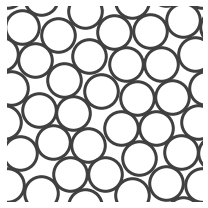

In [ ]:
bubble_positions = simulation(key, temperature=1e-5)
print('bubble_positions.shape = {}'.format(bubble_positions.shape))
draw_system(bubble_positions, box_size, 190)
finalize_plot((0.5, 0.5))

However, this is a small system and we are clearly not using all of the compute in our GPU efficiently. To run an ensemble of simulations at once we use [the JAX function](https://github.com/google/jax#auto-vectorization-with-vmap) `vmap`. Given a function, `f`, `vectorized_f = vmap(f, in_axes, out_axis)` creates a new function with the same behavior as `f` except that it is vectorized over many inputs simultaneously. Specification of which inputs to vectorize is provided by `in_axes`.

Here is an example using `vmap` to vectorize our simulation over many different random keys simultaneously. Note that here `in_axes=(0, None)` to indicate that we want to vectorize over axis 0 of the random keys but we do not want to vectorize over the temeprature.

In [ ]:
# We only want to vectorize over the keys which we denote by in_axis=(0, None).
vectorized_simulation = vmap(simulation, in_axes=(0, None))

Now we can run and draw an ensemble of 9 simulations simultaneously. We see now that `bubble_positions` has shape `(ensemble_size, bubble_count, spatial_dimension)`.

bubble_positions.shape = (9, 32, 2)


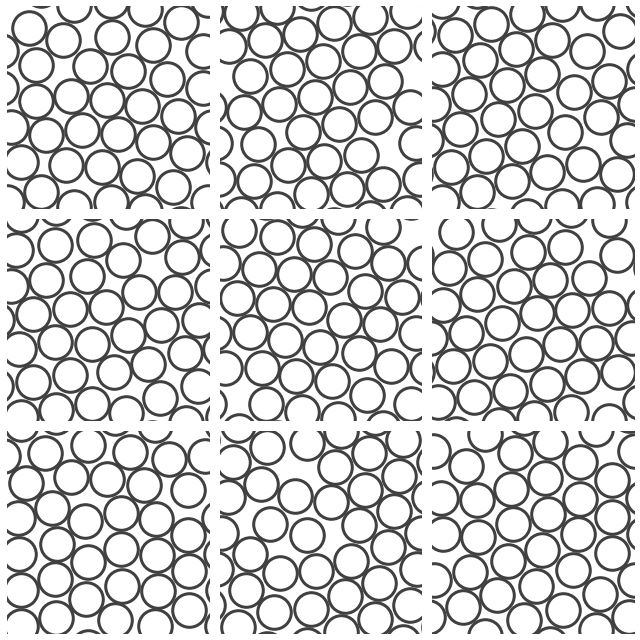

In [ ]:
ensemble_size = 9
simulation_keys = random.split(key, ensemble_size)

bubble_positions = vectorized_simulation(simulation_keys, 1e-5)
print('bubble_positions.shape = {}'.format(bubble_positions.shape))

for i in range(9):
  plt.subplot(3, 3, i + 1)
  draw_system(bubble_positions[i], box_size, 190)

finalize_plot((1.5, 1.5))

We can use this to look at a distribution over the energies of bubble raft configurations by increasing the size of the ensemble significantly.

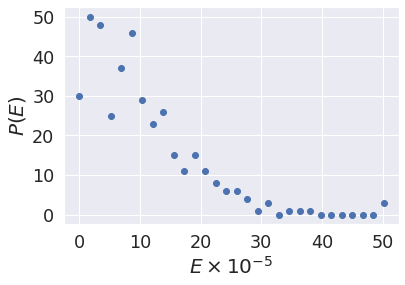

In [ ]:
ensemble_size = 400
simulation_keys = random.split(key, ensemble_size)

vectorized_energy = vmap(energy_fn)

bubble_positions = vectorized_simulation(simulation_keys, 1e-5)
bubble_energies = vectorized_energy(bubble_positions)

counts, bins = onp.histogram(bubble_energies, bins=30)
plt.plot(bins[:-1] * 10 ** 5, counts, 'o')
format_plot('$E\\times 10 ^{-5}$', '$P(E)$')

So far we have vectorized the simulation over only the random key. Another experiment that we can run is to vectorize separately over the key and the temperature. In this way we can run an experiment where we look at how the distribution of energies changes with temperature using a single call to the simulation. We use this to plot the mean and variance of energy as a function of temperature.

We see that the average energy of the bubble rafts and the scale of fluctuations about the mean both increase as a powerlaw with temperature.

A final experiment that we can perform is to measure the time-per-simulation as a function of the number of simulations being vectorized over. We measure this below and plot the result. Because we're trying to get accurate timings for the scaling, this cell can take some time to run.

As expected, we see that the time-per-simulation decreases with the number of simulations being performed in parallel. This scaling continues until the GPU becomes saturated. For a V100 GPU this happens at a batch size of about $2048$.

We will start out by creating a bubble raft using the code from the Automatic Ensembling example. We will then create a dataset of atomic configurations and their respective energies by adding Gaussian distortions atomic positions of a quenched system (as was done by Seko et al. [here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.054113)).  

Now we will split the dataset into a training set and test set. To make the calculation more efficient we will precompute the features. We note, however, that one could compute them online in an active learning setting.

## Optimization Through Dynamics

So far we have demonstrated how JAX MD can make common workloads easier. However, combining molecular dynamics with automatic differentiation opens the door for qualitatively new research. One such avenue involves differentiating through the simulation trajectory to optimize physical parameters. There have been several excellent applications so far in e.g. [protein folding](https://openreview.net/forum?id=Byg3y3C9Km), but until now this has involved significant amounts of specialized code. This vein of research is also similar to recent work in machine learning on [meta-optimization.](https://arxiv.org/abs/1606.04474)

Here we revisit the bubble raft example above. We will show how one can control the structure of the bubble raft by differentiating through the simulation. As we saw, bubble rafts form a hexagonal structure when all of the bubbles have the same size. However, when the bubbles have different sizes the situation can change considerably. To experiment with these changes, we're going to set up a simulation of a bubble raft with bubbles of two distinct sizes. To keep things simple, we'll let half of the bubbles have diameter $1$ and half have diameter $D$.

To control the conditions of the experiment, we will keep the total volume of the bubbles constant. To do this, note that if there are $N$ bubbles then the total volume of water filled by bubbles is,
$$V_{\text{bubbles}} = \frac N8\pi(D^2 + 1)$$
where the factor of $8$ comes from the fact that our system is split into two halves and we are using diameters not radii. Since the volume of our simulation is $V = L^2$ if we want to keep the "packing fraction", $\phi = V_{\text{bubbles}} / V$ constant then we will have to scale the size of the box to be,
$$L = \sqrt{\frac{V_{\text{bubbles}}}{\phi}}.$$
We begin by setting up some experiment parameters and writing a function to compute $L$ as a function of $D$.

In [6]:
N = 128
N_2 = N // 2

simulation_steps = np.arange(300)
dt = 1e-2
temperature = 1e-5

key = random.PRNGKey(0)

packing_fraction = 0.98
markersize = 260

def box_size_at_packing_fraction(diameter):
  bubble_volume = N_2 * np.pi * (diameter ** 2 + 1) / 4
  return np.sqrt(bubble_volume / packing_fraction)

Now we write a simulation similar to the one in the Automatic Ensembling section. This time, however, will take a `diameter` in addition to a key. Additionally, unlike in the previous simulations where we only had one kind of bubble, this time we will have two. This is implemented here using the notion of bubble "species". We will split our bubble raft into two different species of bubbles that we will label $A$ and $B$ respectively. By having two different "species" of bubbles we can define different values of $\sigma$ for interactions between the different species. Since we have two different species this gives us three different $\sigma$ to define: $\sigma_{AA}$, $\sigma_{AB}$, and $\sigma_{BB}$. We know that $\sigma_{AA} = D$ and $\sigma_{BB} = 1$, but what should $\sigma_{AB}$ be? Since the $\sigma$ denote radii, it should be the case that $\sigma_{AB} = \frac12(D + 1)$. We can setup a helper function to setup the species now.

In [20]:
species = np.array([0] * (N_2) + [1] * (N_2), dtype=np.int32)

def species_sigma(diameters):
    diameter_matrix = np.tile(diameters, (diameters.shape[0],1)) 
    return 0.5* (diameter_matrix + diameter_matrix.T)

We will feed the `species` and `sigma` definitions into the `energy.soft_sphere_pair` function. We will also have our simulation return three things: the box size, the final energy, and the final positions. Unlike the previous simulations, we will minimize the energy of the system instead of simulating using brownian motion. To do this we will use the minimizer, `init_fun, apply_fun = minimize.fire_descent(energy_fun, shift_fun)` provided by JAX MD.

In [8]:
from jax_md import minimize

def simulation(diameters, key):
  box_size = box_size_at_packing_fraction(diameter)
  displacement, shift = space.periodic(box_size)

  sigma = species_sigma(diameters)
  energy_fn = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  pos_key, sim_key = random.split(key)

  R = random.uniform(pos_key, (N, 2), maxval=box_size)

  init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)
  state = init_fn(R)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, simulation_steps)

  return box_size, energy_fn(state.position), state.position

Now let's run simulations with two different values of $D$ and draw them side-by-side. In one case we will use $D = 1$ so that both species are the same and this will result in the same hexagonal configuration as in the warm up. However, we will then run a simulation with $D = 0.8$ to see what happens when all the bubbles don't have the same size.

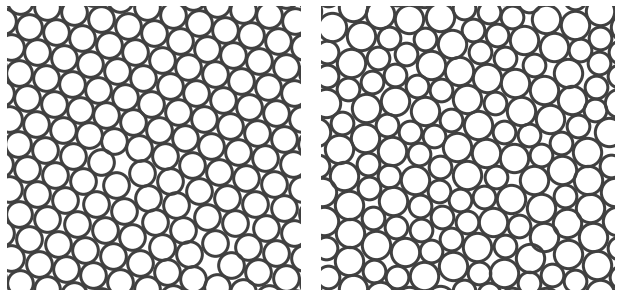

In [9]:
plt.subplot(1, 2, 1)

box_size, raft_energy, bubble_positions = simulation(1.0, key)
draw_system(bubble_positions, box_size, markersize)
finalize_plot((0.5, 0.5))

plt.subplot(1, 2, 2)

box_size, raft_energy, bubble_positions = simulation(0.8, key)
draw_system(bubble_positions[:N_2], box_size, 0.8 * markersize)
draw_system(bubble_positions[N_2:], box_size, markersize)
finalize_plot((2.0, 1))

The hexagonal structure when the bubbles have the same size has broken down in the two-species case. To get a bit more insight into this we will use the automatic vectorization capabilities to see how the structure and energy of bubble rafts depends on `diameter`.

In [ ]:
ensemble_size = 40

# Vectorize over both random keys and diameter.
vec_simulation = vmap(vmap(simulation, (None, 0)), (0, None))

sim_keys = random.split(key, ensemble_size)
diameter = np.linspace(0.4, 1.0, 10)

box_size, raft_energy, bubble_positions = vec_simulation(diameter, sim_keys)

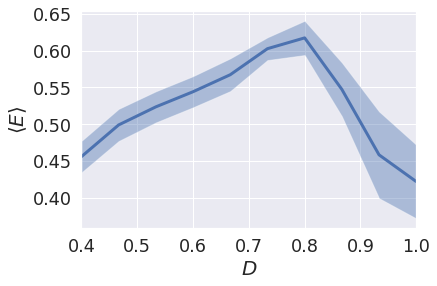

In [ ]:
E_mean = np.mean(raft_energy, axis=1)
E_std = np.std(raft_energy, axis=1)

plt.plot(diameter, E_mean, linewidth=3)
plt.fill_between(diameter, E_mean + E_std, E_mean - E_std, alpha=0.4)

plt.xlim([0.4, 1.0])

format_plot('$D$', '$\\langle E\\rangle$')

At small values of the diameter, the energy is low and increases with increasing diameter until a maximum in the energy at which point it drops precipitously. We can visualize an example system at each of these diameter disparities to see what is happening. We will color the bubble rafts by their energy.

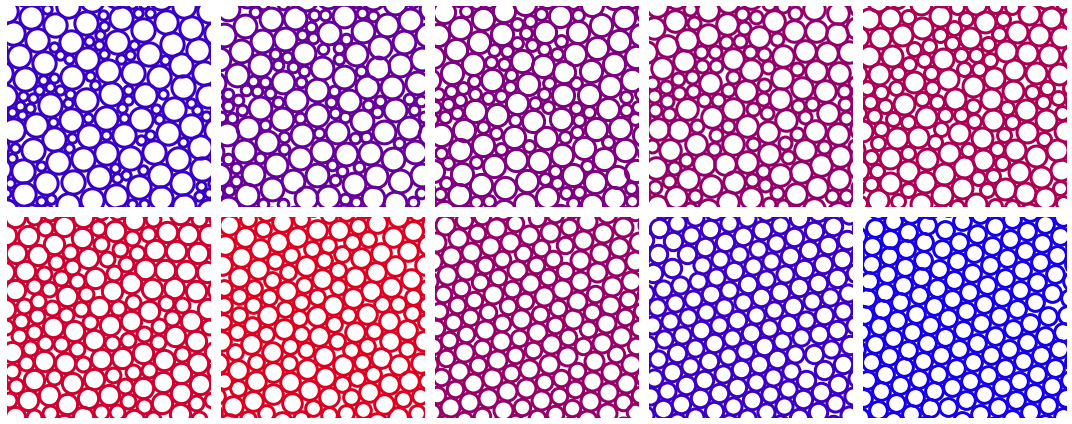

In [ ]:
ms = 180
for i, d in enumerate(diameter):
  # if i % 2:
  #   continue
  plt.subplot(2, 5, i + 1)
  c = min(1, max(0, (E_mean[i] - 0.4) * 4))
  color = [c, 0, 1 - c]
  draw_system(bubble_positions[i, 0, :N_2], box_size[i, 0], d * ms, color=color)
  draw_system(bubble_positions[i, 0, N_2:], box_size[i, 0], ms, color=color)

finalize_plot((2.5, 1))

Notice that when the diameter of the smaller bubbles is very smaller-than or equal-to that of the larger ones, the structure looks much more hexagonal. However, when the diameter is in-between (where the energy is high) the bubbles end up looking like they are arranged randomly. This is an effect known as the [Jamming transition.](https://) However, could we have found this optimally disordered region without brute force? Let's try to maximize the energy with respect to the diameter, $D$, directly.

To do this, we will run short simulation trajectories starting with the positions after minimization that we found above. At the end of the short simulation we will compute the energy of the bubble raft. We will then take the derivative of the energy after the short simulation with respect to the particle diameter.  We're going to make use of the JAX's `grad` function. The function `df_dx = grad(f)` takes a function and returns a new function that computes its gradient with respect to its first argument. Let's now write a shorter simulation function and have it just return the final energy of the system.

In [ ]:
short_simulation_steps = np.arange(10)
def short_simulation(diameter, positions, key):
  box_size = box_size_at_packing_fraction(diameter)
  R = positions / box_size
  displacement, shift = space.periodic_general(box_size * np.eye(2))

  sigma = species_sigma(diameter)
  energy_fn = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  init_fn, apply_fn = minimize.gradient_descent(energy_fn, shift, 1e-3)
  state = init_fn(R)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, short_simulation_steps)

  return energy_fn(state)

Next, let's take the derivative of the energy with respect to the particle diameters and vectorize it over the ensemble of initial positions.


In [ ]:
dE_dD_fun = grad(short_simulation)
dE_dD_fun = jit(vmap(dE_dD_fun, (None, 0, 0)))

Now, we run the simulation for each diameter and record the gradients over each member of the ensemble. We then plot the average gradient against diameter and compare it with the energy that we found by directly simulating the bubble raft.

In [ ]:
dE_dD = []
for i, d in ProgressIter(enumerate(diameter), len(diameter)):
  key, split = random.split(key)
  split = random.split(split, ensemble_size)
  dE_dD += [dE_dD_fun(d, bubble_positions[i], split)]
dE_dD = np.array(dE_dD)

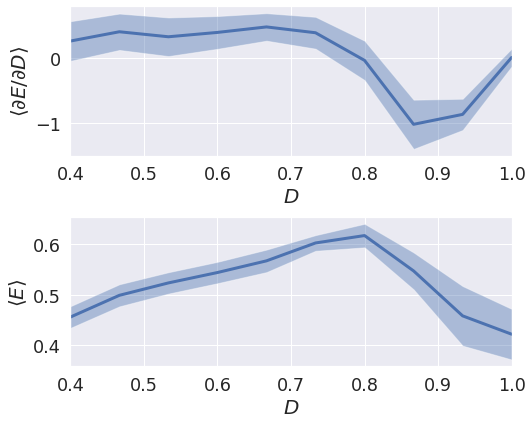

In [ ]:
plt.subplot(2, 1, 1)

dE_mean = np.mean(dE_dD, axis=1)
dE_std = np.std(dE_dD, axis=1)

plt.plot(diameter, dE_mean, linewidth=3)
plt.fill_between(diameter, dE_mean + dE_std, dE_mean - dE_std, alpha=0.4)

plt.xlim([0.4, 1.0])
format_plot('$D$', '$\\langle \\partial E/\\partial D\\rangle$')

plt.subplot(2, 1, 2)
plt.plot(diameter, E_mean, linewidth=3)
plt.fill_between(diameter, E_mean + E_std, E_mean - E_std, alpha=0.4)

plt.xlim([0.4, 1.0])

format_plot('$D$', '$\\langle E\\rangle$')

finalize_plot((1.25, 1))

We see that the gradient is positive and constant for $D < 0.8$ corresponding to the linear increase in the average energy. Moreover, we see that the derivative crosses zero exactly at the maximum average energy. Finally, we observe that the gradient goes back to zero at $D = 1$. This suggests that $D = 0.8$ is the point of maximum disorder, as we found by brute force above. It also shows that $D = 1$ is the minimum energy configuration of the diameter. Although we hadn't hypothesized it, we realize this must be true since $D < 1$ states are symmetric with $D > 1$ as we keep the total packing fraction constant.